In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install googletrans==3.1.0a0 --upgrade --quiet
!pip install xgboost --upgrade --quiet
!pip install catboost --upgrade --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 
import re
import seaborn as sns
from googletrans import Translator, constants
from pprint import pprint
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jaskirat\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jaskirat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jaskirat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Preprocessing

### 1.1 Removing null values 

In [4]:
project_data = pd.read_csv('HOT_Dataset_modified.csv', header=None)
project_data = project_data.iloc[0::, 0:2]
project_data.head()

,0,1
0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...
1,NaN,NaN
2,2.0,"Banti hai empowered woman, feminism pe gyan pe..."
3,NaN,NaN
4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...


In [5]:
project_data = project_data.dropna(how='all')

In [6]:
project_data.head()

,0,1
0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...
2,2.0,"Banti hai empowered woman, feminism pe gyan pe..."
4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...
6,2.0,@InviSibleSold @mabkhan86 @dridadahn Punjab in...
8,2.0,RT @MrMonsterSaid: Agar koi bole ki ja ke chil...


In [7]:
project_data.shape

(3189, 2)

In [8]:
project_data[0].value_counts()

2.0    1765
0.0    1121
1.0     303
Name: 0, dtype: int64

### 1.2 Labelling columns

In [9]:
project_data.columns = ['label', 'tweet']

In [10]:
project_data.head()

,label,tweet
0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...
2,2.0,"Banti hai empowered woman, feminism pe gyan pe..."
4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...
6,2.0,@InviSibleSold @mabkhan86 @dridadahn Punjab in...
8,2.0,RT @MrMonsterSaid: Agar koi bole ki ja ke chil...


In [11]:
project_data.isnull().any()

label    False
tweet    False
dtype: bool

## 2. Exploratory Data Analysis

### 2.1 Visualizing the tweets (category-wise)

Number of tweets that are Non Abusive 1121 , ( 35.152085293195356 %)
Number of tweets that are Hate Speech 303 , ( 9.501411100658514 %)
Number of tweets that are abusive 1765 , ( 55.34650360614612 %)


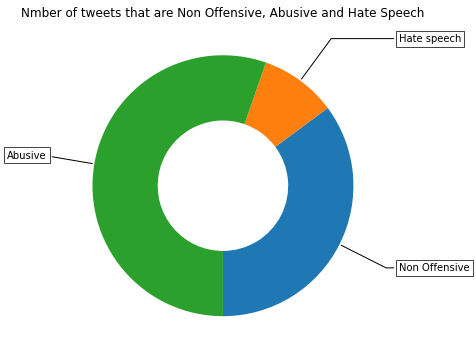

In [12]:
# this code is taken from 
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = project_data['label'].value_counts()
print("Number of tweets that are Non Abusive", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[0]+y_value_counts[1]+y_value_counts[2]))*100,"%)")
print("Number of tweets that are Hate Speech", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]+y_value_counts[2]))*100,"%)")
print("Number of tweets that are abusive", y_value_counts[2], ", (", (y_value_counts[2]/(y_value_counts[1]+y_value_counts[0]+y_value_counts[2]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Non Offensive", "Hate speech", "Abusive"]

data = [y_value_counts[0], y_value_counts[1], y_value_counts[2]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-90)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of tweets that are Non Offensive, Abusive and Hate Speech")

plt.show()

### 2.2 Number of words in tweets

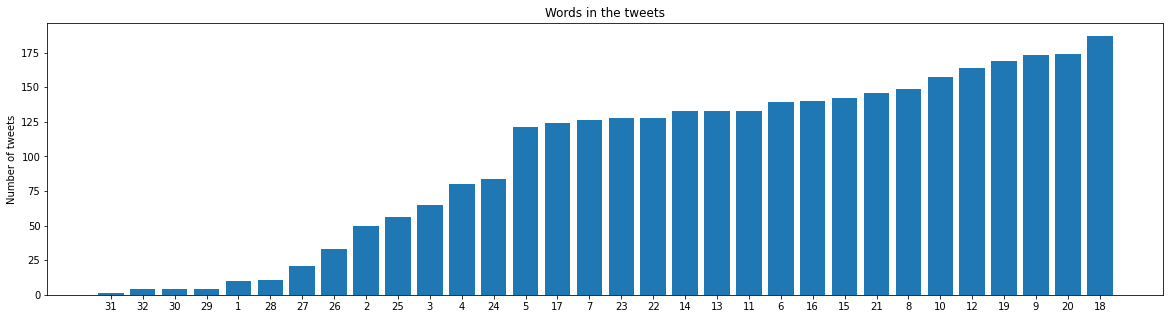

In [13]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of tweets')
plt.title('Words in the tweets')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

The length of tweet varies between 1 to 32 here. The maximum numbers of tweets is 175 according to length of words which 18.

In [14]:
# grouping tweets

group_tweets = project_data.groupby('label')
non_offensive = group_tweets.get_group(0.0)
abusive = group_tweets.get_group(2.0)
hate_speech = group_tweets.get_group(1.0)

#### 2.2.1 Number of words in non offensive tweets

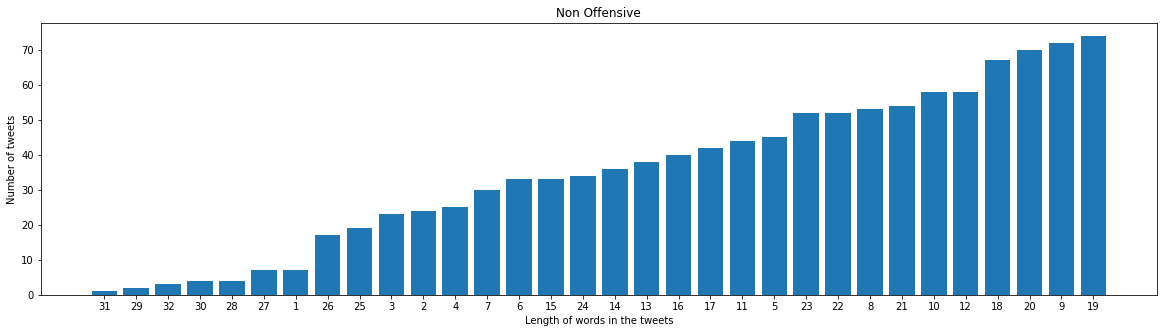

In [15]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = non_offensive['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.xlabel('Length of words in the tweets')
plt.ylabel('Number of tweets')
plt.title('Non Offensive')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### 2.2.2 Number of words in abusive tweets

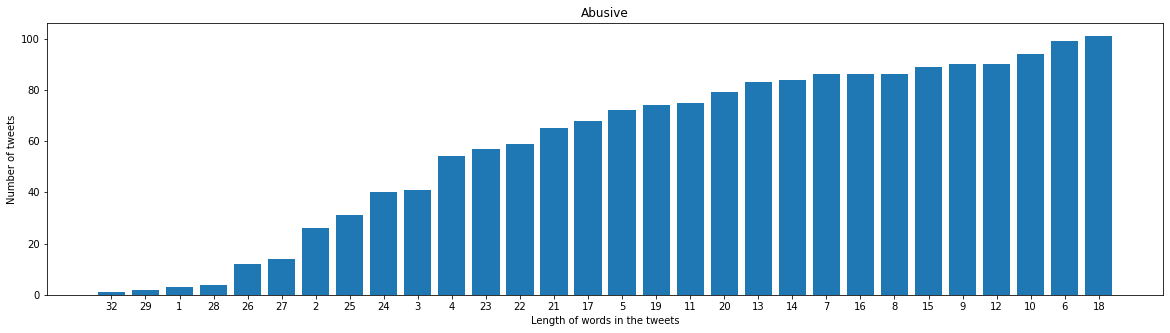

In [16]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = abusive['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.xlabel('Length of words in the tweets')
plt.ylabel('Number of tweets')
plt.title('Abusive')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

#### 2.2.3 Number of words in hate speech tweets

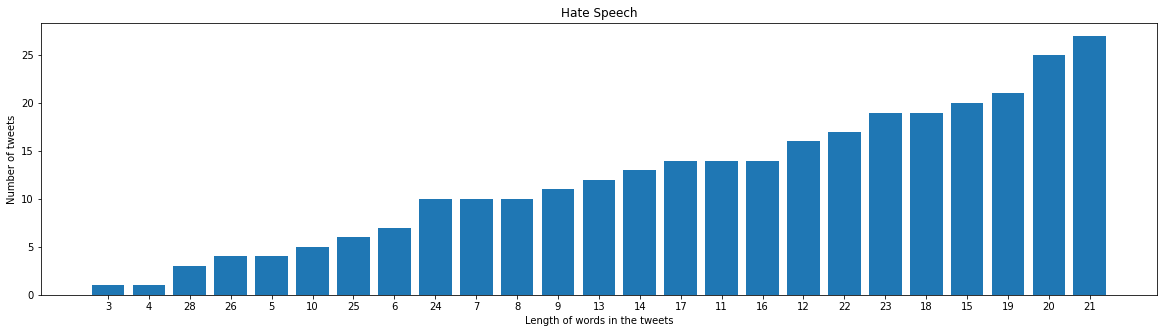

In [17]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = hate_speech['tweet'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.xlabel('Length of words in the tweets')
plt.ylabel('Number of tweets')
plt.title('Hate Speech')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

### 2.3 Box plot with number of words in each category of tweets

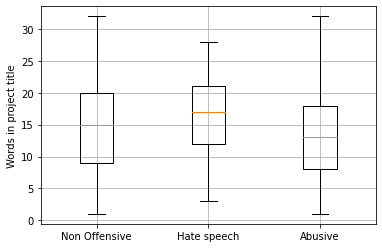

In [18]:
non_offensive_word_count = non_offensive['tweet'].str.split().apply(len).values

hate_speech_word_count = hate_speech['tweet'].str.split().apply(len).values

abusive_word_count = abusive['tweet'].str.split().apply(len).values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([non_offensive_word_count, hate_speech_word_count, abusive_word_count])
plt.xticks([1,2,3],("Non Offensive", "Hate speech", "Abusive"))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

From Box Plots, we can analyse that the IQR of word length of tweets in hate speech are between 13 to 21. While the abusive are between 8 to 17 and the Non Offensive are between 9 to 20.

### 2.4 PDF Plot with number of words in each category of tweets

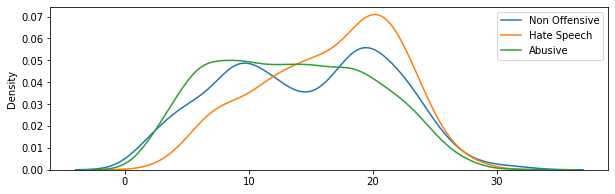

In [19]:
plt.figure(figsize=(10,3))
sns.distplot(non_offensive_word_count, hist=False, label="Non Offensive")
sns.distplot(hate_speech_word_count, hist=False, label="Hate Speech")
sns.distplot(abusive_word_count, hist=False, label="Abusive")

plt.legend()
plt.show()

### 2.5 Word Clouds

#### 2.5.1 For non-offensive tweets

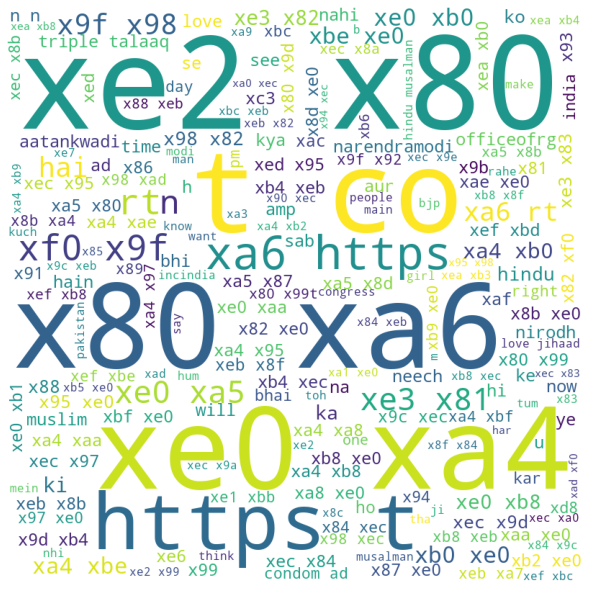

In [20]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in non_offensive['tweet']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


#### 2.5.2 For abusive tweets 

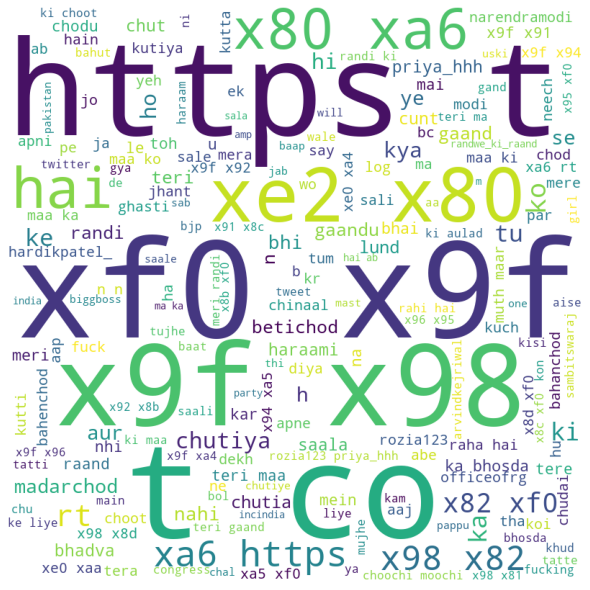

In [21]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in abusive['tweet']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


#### 2.5.3 For hate speech tweets

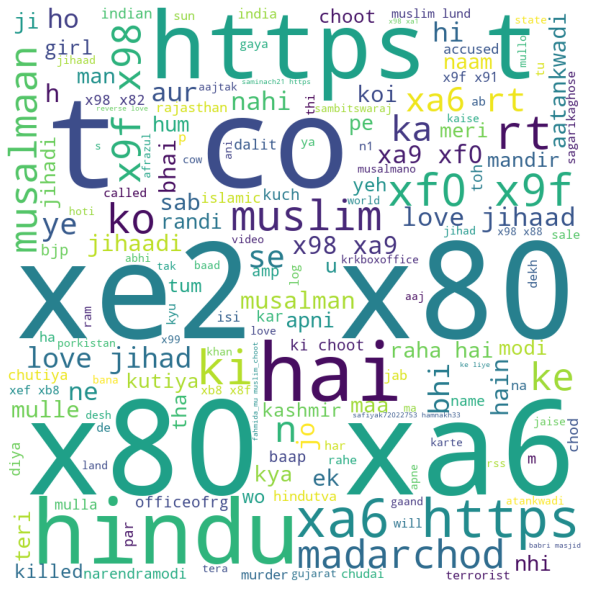

In [22]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in hate_speech['tweet']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [23]:
hate_speech['tweet']

10      @InviSibleSold @mabkhan86 @dridadahn Main jutt...
18      RT @AnshKSpeaks: Screw the law of the land. If...
38      *Virat and Anushka's future kid*\n\nAnushka: M...
40      @dasraghubar @narendramodi @AmitShah @BJP4Indi...
60      @NANGI_POOJA Madarchod musalman aaiysha aur wo...
                              ...                        
6370    @zyanmalik0011 @SariaW @asadowaisi @ZairaWasim...
6372    @MamataOfficial all love jihaadi should ne kil...
6374    @zyanmalik0011 @SariaW @asadowaisi @ZairaWasim...
6376    @MirAda94 @anuragsinghrana @bukharishujaat @Al...
6378    @FarahKhanAli @anerao15 Kya madam, abhi tak ap...
Name: tweet, Length: 303, dtype: object

## 3. Data Cleaning

In [24]:
def userid(tweet):
    ''' This function calculates the number of userids in the tweets'''
    count = 0
    for i in tweet.split():
        if i[0] == '@':
            count += 1
    return count

def profanity_vector(tweet):
    
    ''' This functions calculates the profanity vector for a given tweet '''
    
    bad_words = pd.read_csv('Hinglish_Profanity_List.csv', encoding='mac_roman', engine='python', header=None)
    bad_words.columns = ['Hinglish', 'English', 'Level']
    hinglish = bad_words['Hinglish'].values
    level = bad_words['Level'].values
    PV = [0] * len(level)
    for word in tweet.split():
        if word in hinglish:
            idx = np.where(hinglish == word)
            PV[level[idx][0]] = 1
    return PV

def translation(tweet):
    
    ''' This function translates the hinglish tweet into english '''
    translator = Translator()
    trans = translator.translate(tweet)
    trans_tweet = trans.text
    
    return trans_tweet.lower()

def stopword(data):
    
    ''' This function removes the stopwords from the given sentence'''
    clean = []
    stop_words = set(STOPWORDS)
    
    for tweet in data:
        sentence = []
        for word in tweet.split():
            if word not in stop_words:
                sentence.append(word)
        clean.append(sentence)
    return clean

def Lemmatizer(tweet):
    
    ''' This function uses NLTK lemmatization method and clean the sentence'''
    lemma = []
    lemmatizer = WordNetLemmatizer()
    
    for word in tweet:
        sentence = []
        for i in word:
             sentence.append(lemmatizer.lemmatize(i))
        lemma.append(' '.join(sentence))
    return lemma

def SID(tweet):
    
    ''' This function calculates the NLTK sentiments and return the negative, neutral, postive and compound values'''
    negative = []
    neutral = []
    positive = []
    compound = []
    
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(tweet)
    
    negative.append(sentiment_score['neg'])
    neutral.append(sentiment_score['neu'])
    positive.append(sentiment_score['pos'])
    compound.append(sentiment_score['compound'])
    
    return negative, neutral, positive, compound


def cleaning(data):
    
    ''' This functions clean the input text'''
    
    user_ids = []
    clean_data_hinglish = []
    clean_translated_data = []
    prof_vector = []
    
    for tweet in tqdm(data):
        userids = userid(tweet)
        clean_text = []
        tweet = re.sub(r'\\n', ' ', tweet)  # replacing '\\n' with a space
        tweet = re.sub(r',', ' ', tweet)    # replacing ','  with a space
        tweet = re.sub(r'RT|rt', '', tweet)
        
        for word in tweet.split():
            if word[0] == '@':              # removing user_ids 
                clean_word = re.sub(word, 'username', word)
            else:
                clean_word = word.lower()       # lowercase all the words
                clean_word = re.sub(r'^#\w+', ' ', clean_word)
                #clean_word = re.sub(r'^\\[a-z0-9].*\\[a-z0-9{3}+]*[^\\n]$', '', clean_word)   # removing emotions in unicode
                clean_word = re.sub(r'\\', ' ', clean_word)
                clean_word = re.sub(r'^https:[\a-zA-Z0-9]+', '', clean_word)              # replacing url link with 'url'
                #clean_word = re.sub(r'[^a-z].\w+', '', clean_word)           # removing evering thing except a-z
                clean_word = re.sub(r'[!,.:_;$%^\'\#"&]', '', clean_word)
                clean_text.append(clean_word)
                
        clean_text = (' ').join(clean_text)
    
        PV = profanity_vector(clean_text)  # calling profanity_vector function
        translated_tweet = translation(clean_text)  #calling translated_tweet function
        
        user_ids.append(userids)
        clean_data_hinglish.append(clean_text)
        clean_translated_data.append(translated_tweet)
        prof_vector.append(PV)
        
        
    clean_data_hinglish = np.asarray(clean_data_hinglish)
    user_ids = np.asarray(user_ids).reshape(-1,1)
    prof_vector = np.asarray(prof_vector)
    clean_translated_data = np.asarray(clean_translated_data)

        
    return clean_data_hinglish, user_ids, prof_vector, clean_translated_data

In [25]:
# creating a dataframe with the clean data
# dataframe_clean = pd.DataFrame(list(zip(clean_data_hinglish, clean_translated_data, project_data['label'].values)),\
#                                columns=['Hinglish_Data_Clean', 'Translated_Data_Clean', 'Label'])

clean_data_hinglish, user_ids, prof_vector, clean_translated_data = cleaning(r for r in hate_speech['tweet'])

dataframe_clean = pd.DataFrame(list(zip(clean_data_hinglish, clean_translated_data, project_data['label'].values)),\
                               columns=['Hinglish_Data_Clean', 'Translated_Data_Clean', 'Label'])

303it [02:04,  2.43it/s]


In [26]:
#grouping with the target label

group_tweets_clean = dataframe_clean.groupby('Label')
non_offensive_clean = group_tweets_clean.get_group(0.0)
abusive_clean = group_tweets_clean.get_group(2.0)
hate_speech_clean = group_tweets_clean.get_group(1.0)

### 3.1 Word clouds after cleaning

#### 3.1.1 For non-offensive tweets

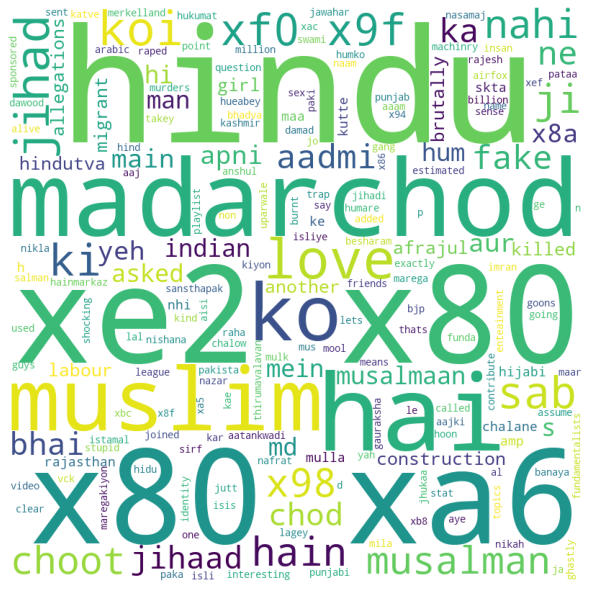

In [27]:
# Python program to generate WordCloud only for Non_Offensive tweets after cleaning

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in non_offensive_clean['Hinglish_Data_Clean']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


#### 3.1.2 For abusive tweets

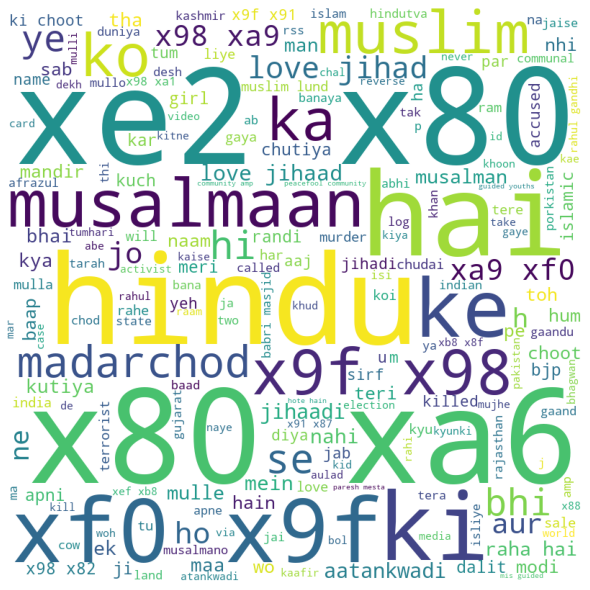

In [28]:
# Python program to generate WordCloud only for Abusive tweets after cleaning

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in abusive_clean['Hinglish_Data_Clean']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

#### 3.1.3 For hate speech tweets

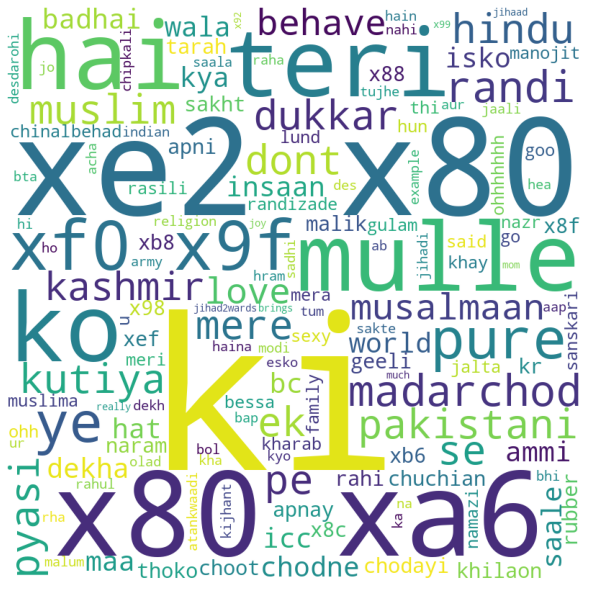

In [29]:
# Python program to generate WordCloud only for Hate Speech tweets after cleaning

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in hate_speech_clean['Hinglish_Data_Clean']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## 4. Function for Feature Engineering

In [30]:
def feature_process(clean_data_train, clean_data_test, userids_train, userids_test, PV_train, PV_test):
    ''' This function except the clean data and return Train and Test dataset after stacking userids, profanity vector, negative sentiment, neutral sentiment, 
                    positive sentiment, compound sentiment, n-grams and tfidf features'''
    
    vectorizer = CountVectorizer()
    tfidf = TfidfVectorizer()
    negative_train, negative_test = [], []
    neutral_train, neutral_test = [], []
    positive_train, positive_test  = [], []
    compound_train, compound_test  = [], []

    for tweet in clean_data_train:
        neg, neu, pos, comp = SID(tweet)
        negative_train.append(neg), neutral_train.append(neu), positive_train.append(pos), compound_train.append(comp)
    
    for tweet in clean_data_test:
        neg, neu, pos, comp = SID(tweet)
        negative_test.append(neg), neutral_test.append(neu), positive_test.append(pos), compound_test.append(comp)
    
    clean_data_SW_train = stopword(clean_data_train)
    clean_data_SW_test = stopword(clean_data_test)
    
    clean_data_lemm_train = Lemmatizer(clean_data_SW_train)
    clean_data_lemm_test = Lemmatizer(clean_data_SW_test)
    
    vectorizer.fit(clean_data_lemm_train)
    tfidf.fit(clean_data_lemm_train)
    
    n_grams_train = vectorizer.transform(clean_data_lemm_train)
    tfidf_ngrams_train = tfidf.transform(clean_data_lemm_train)
    
    n_grams_test = vectorizer.transform(clean_data_lemm_test)
    tfidf_ngrams_test = tfidf.transform(clean_data_lemm_test)
    
    negative_train, negative_test = np.asarray(negative_train), np.asarray(negative_test)
    neutral_train, neutral_test = np.asarray(neutral_train), np.asarray(neutral_test)
    positive_train, positive_test  = np.asarray(positive_train), np.asarray(positive_test)
    compound_train, compound_test = np.asarray(compound_train), np.asarray(compound_test)
    
    train_dataset = hstack((user_ids_train, PV_train, negative_train, neutral_train, positive_train, compound_train, n_grams_train, tfidf_ngrams_train))
    
    test_dataset = hstack((user_ids_test, PV_test, negative_test, neutral_test, positive_test, compound_test, n_grams_test, tfidf_ngrams_test))
    
    
    return train_dataset, test_dataset

### 4.1 Spliting train and test dataset into 80:20 

In [31]:
X = project_data['tweet']
y = project_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

In [32]:
X_train

3546    RT @ShareeefAF: aik tou bhai tunay sai gaand m...
5498    RT @krupashanker: That is the GODRA moment in ...
710     @ShkhRasheed Taryi ghasti behen ko chodon sary...
5184    @kdsindhi @iqrarulhassan Aise Pakistani, Musal...
6058    In 21st century the rights which Hindu women a...
                              ...                        
6182    @aajtak @myogiadityanath Rahul Gandhi Babri Ma...
5833    RT @AsYouNotWish: Another girl gang-raped by a...
4314    @sardanarohit Oh shit i read it Bena nirodh ad...
660     @Your_Daddy123 @Mes_tizo @sundas_pasha @Prnces...
522     @uksri CHINAAL KE RUK TO JAA.....CHOOT MARANI ...
Name: tweet, Length: 2551, dtype: object

In [33]:
# calling the cleaning function which returns the values for the train dataset.

clean_data_hinglish_train, user_ids_train, prof_vector_train, clean_translated_data_train = cleaning(X_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 2551/2551 [17:11<00:00,  2.47it/s]


In [35]:
# calling the cleaning function which returns the values for the test dataset

clean_data_hinglish_test, user_ids_test, prof_vector_test, clean_translated_data_test = cleaning(X_test)

100%|███████████████████████████████████████████████████████████████████████████████████| 638/638 [04:07<00:00,  2.58it/s]


In [36]:
# calling feature_process which returns the complete train and test dataset.

Train, Test = feature_process(clean_translated_data_train, clean_translated_data_test, user_ids_train, user_ids_test, prof_vector_train, prof_vector_test)

In [37]:
print('{} is the shape of Train Dataset and {} is the shape of Test Dataset'.format(Train.shape, Test.shape))

(2551, 11770) is the shape of Train Dataset and (638, 11770) is the shape of Test Dataset


In [38]:
def plot_confusion_matrix(test_y, predict_y):
    
    '''This function returns confusion matrix, precison matrix and recall matrix for 3 class classification'''
    
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = ['Non Offensive', 'Hate Speech', 'Abusive']
    cmap=sns.light_palette("green")
    
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in Recall matrix",A.sum(axis=1))

## 5. Applying different models

### 5.1 Support Vector Machine with Grid Search Cross Validation

#### 5.1.1 Support Vector Machine with Linear Kernel

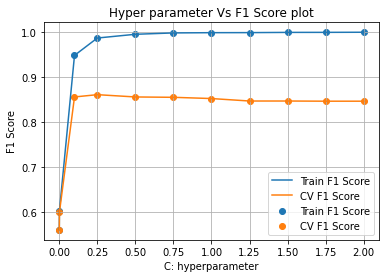

In [39]:
svm = SVC(gamma='auto')
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0], 'kernel': ['linear']}
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [40]:
clf.best_params_

{'C': 0.25, 'kernel': 'linear'}

Number of misclassified points  11.285266457680251
-------------------------------------------------- Confusion matrix --------------------------------------------------


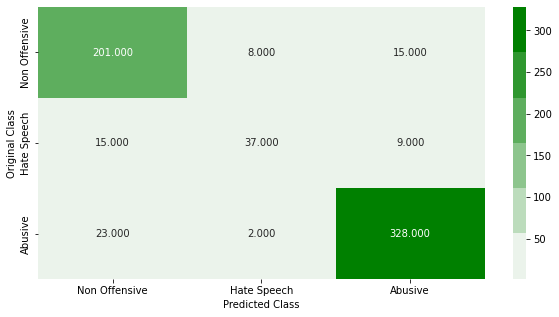

-------------------------------------------------- Precision matrix --------------------------------------------------


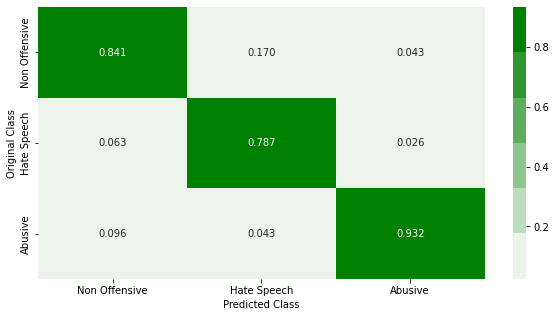

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


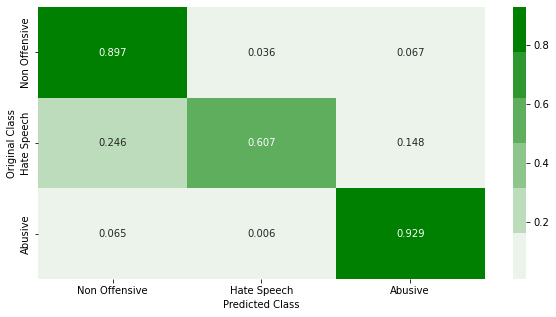

Sum of rows in Recall matrix [1. 1. 1.]


In [41]:
svm_clf = SVC(C=0.25, gamma='auto', kernel='linear')
svm_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf.predict(Test))

#### 5.1.2 Support Vector Machine with RBF Kernel

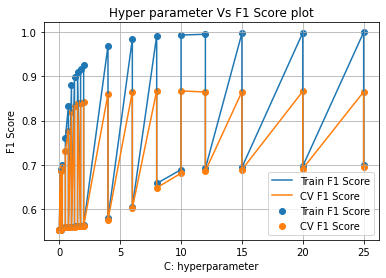

In [42]:
svm = SVC(kernel='rbf')
parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0, 4, 6, 8, 10, 12, 15, 20, 25], 'gamma':['scale', 'auto'],  }
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [43]:
clf.best_params_

{'C': 8, 'gamma': 'scale'}

Number of misclassified points  11.598746081504702
-------------------------------------------------- Confusion matrix --------------------------------------------------


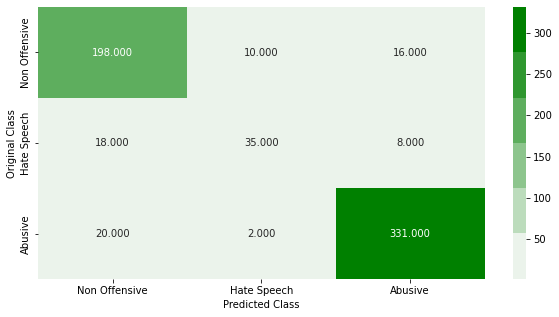

-------------------------------------------------- Precision matrix --------------------------------------------------


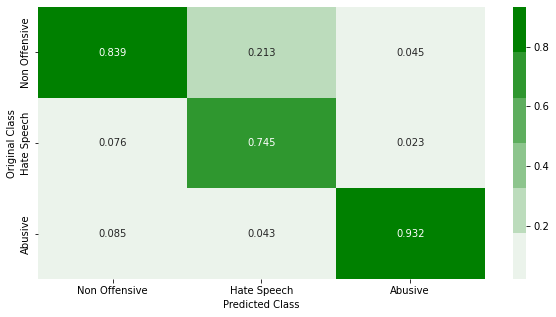

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


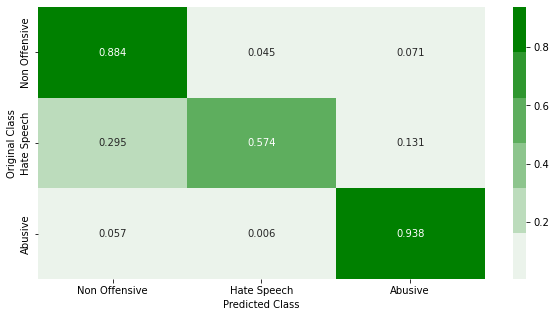

Sum of rows in Recall matrix [1. 1. 1.]


In [44]:
svm_clf_rbf = SVC(C=8, gamma='scale', kernel='rbf')
svm_clf_rbf.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf_rbf.predict(Test))

#### 5.1.3 Support Vector Machine with Polynominal Kernel

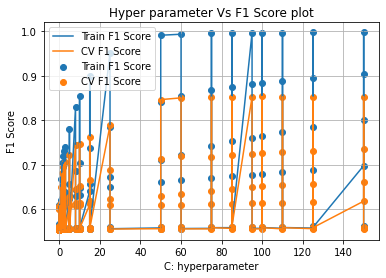

In [45]:
svm = SVC(kernel='poly')
parameters = {'C':[ 0.0001, 0.001, 0.1, 1,  1.5, 2.0, 2.5, 3, 5, 8, 10, 15, 25, 50, 60, 75, 85, 95, 100, 110, 125, 150], \
              'gamma':['scale', 'auto'], 'degree': [2,3,4,5]  }
clf = GridSearchCV(svm, parameters, cv=10, scoring='f1_micro', return_train_score=True, n_jobs=-1)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_C']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [46]:
clf.best_params_

{'C': 100, 'degree': 2, 'gamma': 'scale'}

Number of misclassified points  11.912225705329153
-------------------------------------------------- Confusion matrix --------------------------------------------------


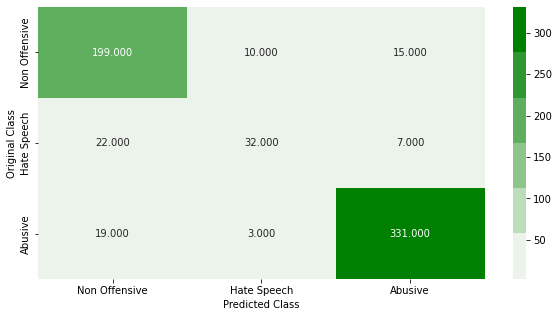

-------------------------------------------------- Precision matrix --------------------------------------------------


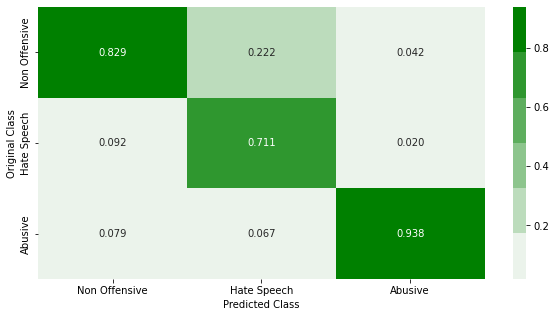

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


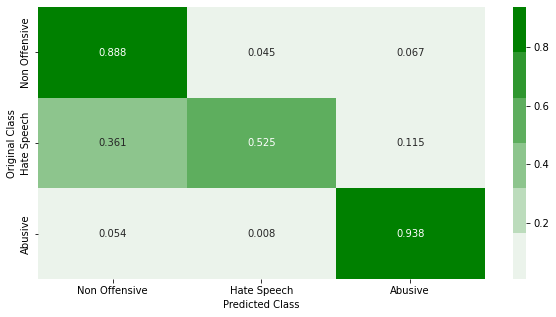

Sum of rows in Recall matrix [1. 1. 1.]


In [47]:
svm_clf_poly = SVC(C=75, gamma='scale', degree=2, kernel='poly')
svm_clf_poly.fit(Train, y_train)
plot_confusion_matrix(y_test, svm_clf_poly.predict(Test))

### 5.2 Logistic Regression 

In [48]:
# LR = LogisticRegression(max_iter=500, random_state=42)
# parameters = {'C':[ 0.0001, 0.001, 0.1, 0.25, 0.50, 0.75, 1, 1.25, 1.5, 1.75, 2.0], 'penalty':['l1', 'l2', 'elasticnet']}

# clf = GridSearchCV(LR, parameters, cv=10, scoring='f1_micro', return_train_score=True)
# clf.fit(Train, y_train)

# results = pd.DataFrame.from_dict(clf.cv_results_)
# results = results.sort_values(['param_C'])

# train_score= results['mean_train_score']
# cv_score = results['mean_test_score'] 
# alpha =  results['param_C']

# plt.plot(alpha, train_score, label='Train F1 Score')
# # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# # plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

# plt.plot(alpha, cv_score, label='CV F1 Score')
# # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# # plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

# plt.scatter(alpha, train_score, label='Train F1 Score')
# plt.scatter(alpha, cv_score, label='CV F1 Score')

# plt.legend()
# plt.xlabel("C: hyperparameter")
# plt.ylabel("F1 Score")
# plt.title("Hyper parameter Vs F1 Score plot")
# plt.grid()
# plt.show()

In [49]:
# clf.best_params_

In [50]:
# LR_clf = LogisticRegression(C= 0.75, max_iter=500, penalty='l2', random_state=42)
# LR_clf.fit(Train, y_train)
# plot_confusion_matrix(y_test, LR_clf.predict(Test))

### 5.3 Decision Tree Classifier

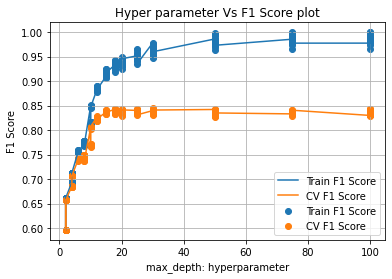

In [51]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
parameters = {'criterion':['gini', 'entropy'], 'max_depth': [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 75, 100], \
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 10]}
clf = GridSearchCV(DTC, parameters, cv=10, scoring='f1_micro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_max_depth']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("max_depth: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()


In [52]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 3}

Number of misclassified points  13.479623824451412
-------------------------------------------------- Confusion matrix --------------------------------------------------


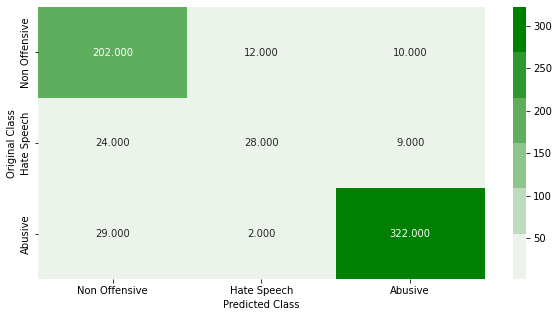

-------------------------------------------------- Precision matrix --------------------------------------------------


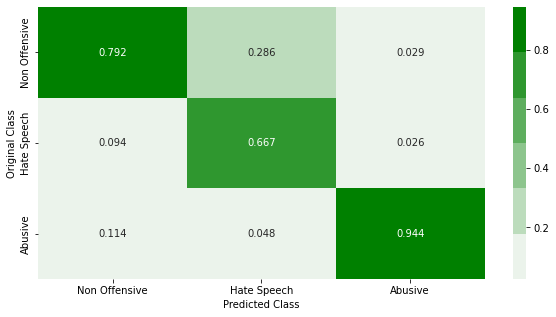

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


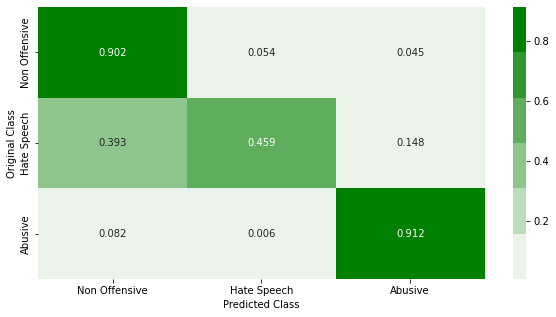

Sum of rows in Recall matrix [1. 1. 1.]


In [53]:
DTC_clf = DecisionTreeClassifier(criterion='gini', max_depth=18, min_samples_split=2)
DTC_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, DTC_clf.predict(Test))

### 5.4  K-Nearest Neighbour Classifier

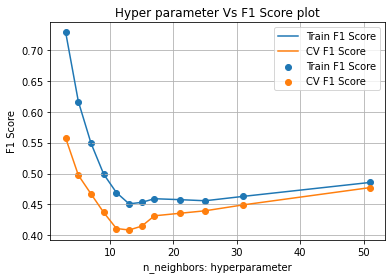

In [54]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
KNN = KNeighborsClassifier()
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17, 21, 25, 31, 51, ]}
clf = GridSearchCV(KNN, parameters, cv=10, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_neighbors'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_neighbors']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_neighbors: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [55]:
clf.best_params_

{'n_neighbors': 3}

Number of misclassified points  29.310344827586203
-------------------------------------------------- Confusion matrix --------------------------------------------------


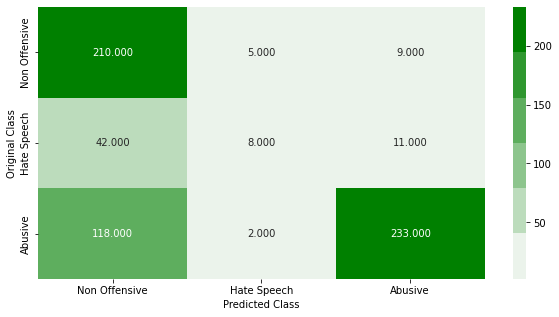

-------------------------------------------------- Precision matrix --------------------------------------------------


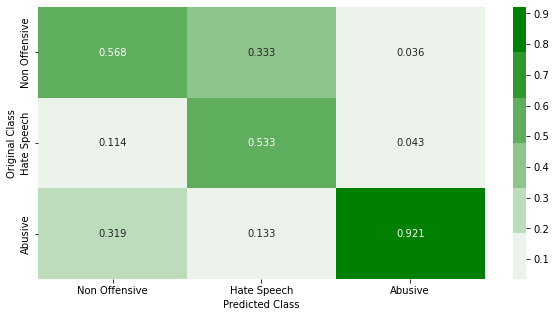

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


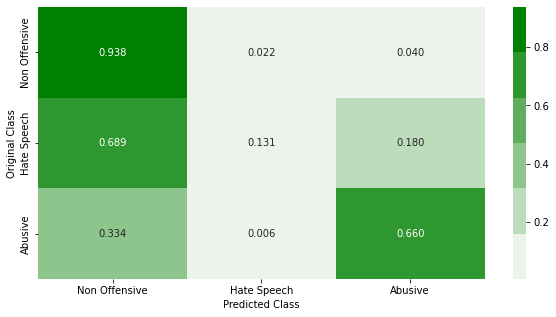

Sum of rows in Recall matrix [1. 1. 1.]


In [56]:
from sklearn.neighbors import KNeighborsClassifier
KNN_clf = KNeighborsClassifier(n_neighbors=3)
KNN_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, KNN_clf.predict(Test))

### 5.5 Extra Tree Classifiers

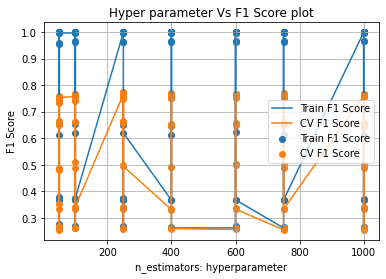

In [57]:
ETC = ExtraTreesClassifier(n_jobs=-1)
parameters = {'n_estimators':[ 50,100,250, 400, 600, 750, 1000], 'criterion': ['gini', 'entropy'], \
              'max_depth': [5, 10, 20, 50, 100, 200, 300, 400, 500, 750]}
clf = GridSearchCV(ETC, parameters, cv=10, scoring='f1_macro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [58]:
clf.best_params_

{'criterion': 'entropy', 'max_depth': 200, 'n_estimators': 250}

Number of misclassified points  12.068965517241379
-------------------------------------------------- Confusion matrix --------------------------------------------------


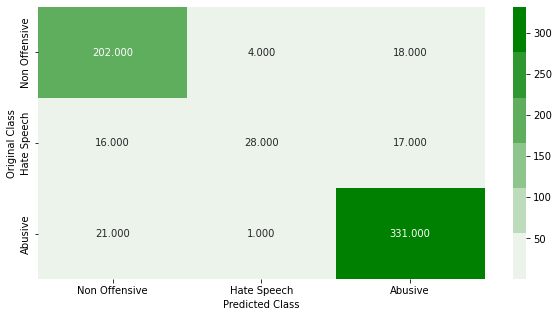

-------------------------------------------------- Precision matrix --------------------------------------------------


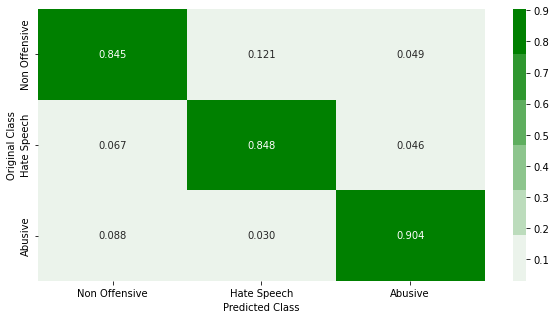

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


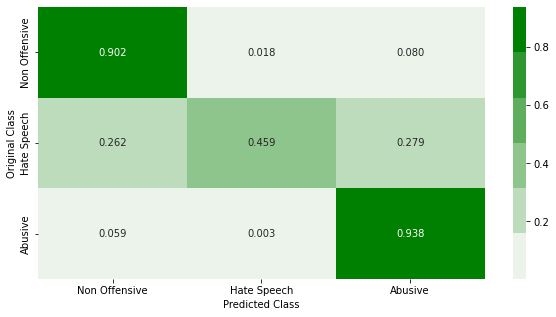

Sum of rows in Recall matrix [1. 1. 1.]


In [59]:
ETC_clf = ExtraTreesClassifier(criterion='gini', max_depth=200, n_estimators=500, n_jobs=-1)
ETC_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, ETC_clf.predict(Test))

### 5.6 Random Forest Classifier

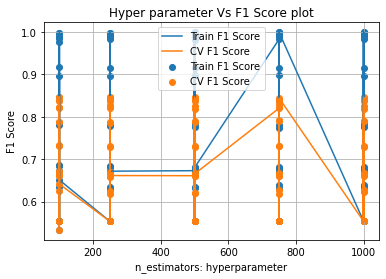

In [60]:
RF = RandomForestClassifier(n_jobs=-1)
parameters={
     'n_estimators': [100, 250, 500, 750, 1000],
     'max_depth': [5,8,10, 20, 50, 100, 250, 500 ],
    'max_samples' : [0.6, 0.75, 1],
}
clf = GridSearchCV(RF, parameters, cv=10, scoring='f1_micro', n_jobs=-1, return_train_score=True)
clf.fit(Train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_n_estimators'])

train_score= results['mean_train_score']
cv_score = results['mean_test_score'] 
alpha =  results['param_n_estimators']

plt.plot(alpha, train_score, label='Train F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_score, label='CV F1 Score')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_score, label='Train F1 Score')
plt.scatter(alpha, cv_score, label='CV F1 Score')

plt.legend()
plt.xlabel("n_estimators: hyperparameter")
plt.ylabel("F1 Score")
plt.title("Hyper parameter Vs F1 Score plot")
plt.grid()
plt.show()

In [61]:
clf.best_params_

{'max_depth': 250, 'max_samples': 0.75, 'n_estimators': 250}

Number of misclassified points  14.106583072100312
-------------------------------------------------- Confusion matrix --------------------------------------------------


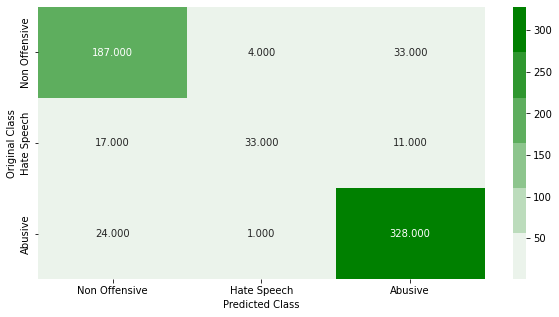

-------------------------------------------------- Precision matrix --------------------------------------------------


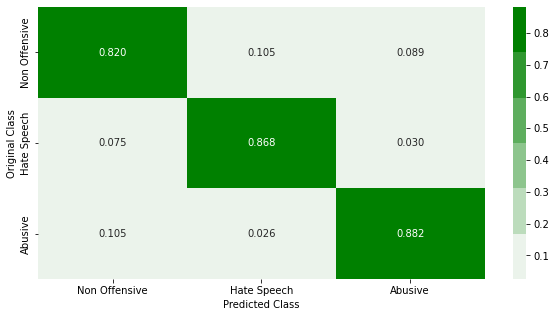

Sum of columns in precision matrix [1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


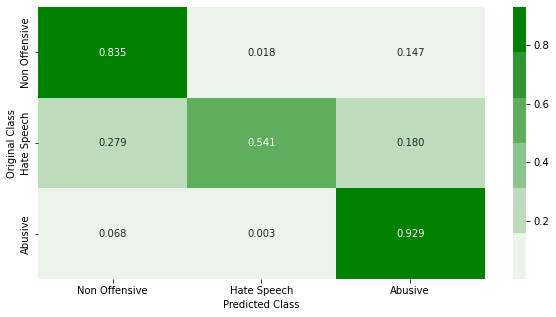

Sum of rows in Recall matrix [1. 1. 1.]


In [62]:
RF_clf = RandomForestClassifier(n_estimators=250, max_depth=250, max_samples=0.75, n_jobs=-1)
RF_clf.fit(Train, y_train)
plot_confusion_matrix(y_test, RF_clf.predict(Test))

## 6. Summary of Models

In [76]:
!pip install prettytable


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
from prettytable import PrettyTable
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
myTable = PrettyTable(["Model","Train / Test", "Accuray", "F1-Score", "Precison", "Recall"])
  
# Add rows
myTable.add_row(["KNN", "Train", np.round(accuracy_score(y_train, KNN_clf.predict(Train)), 6), np.round(f1_score(y_train, KNN_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, KNN_clf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, KNN_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["KNN", "Test", np.round(accuracy_score(y_test, KNN_clf.predict(Test)), 6), np.round(f1_score(y_test, KNN_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-Linear", "Train", np.round(accuracy_score(y_train, svm_clf.predict(Train)), 6), np.round(f1_score(y_train, svm_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-Linear", "Test", np.round(accuracy_score(y_test, svm_clf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-RBF", "Train", np.round(accuracy_score(y_train, svm_clf_rbf.predict(Train)), 6), np.round(f1_score(y_train, svm_clf_rbf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf_rbf.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf_rbf.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-RBF", "Test", np.round(accuracy_score(y_test, svm_clf_rbf.predict(Test)), 6), np.round(f1_score(y_test, svm_clf_rbf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf_rbf.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf_rbf.predict(Test), average='macro'), 6)])

myTable.add_row(["SVC-Poly", "Train", np.round(accuracy_score(y_train, svm_clf_poly.predict(Train)), 6), np.round(f1_score(y_train, svm_clf_poly.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, svm_clf_poly.predict(Train), average='macro'), 6), \
                 np.round(recall_score(y_train, svm_clf_poly.predict(Train), average='macro'), 6)])

myTable.add_row(["SVC-Poly", "Test", np.round(accuracy_score(y_test, svm_clf_poly.predict(Test)), 6), np.round(f1_score(y_test, svm_clf_poly.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, svm_clf_poly.predict(Test), average='macro'), 6), \
                 np.round(recall_score(y_test, svm_clf_poly.predict(Test), average='macro'), 6)])

# myTable.add_row(["Logistic Regression","Train", np.round(accuracy_score(y_train, LR_clf.predict(Train)), 6), np.round(f1_score(y_train, LR_clf.predict(Train),\
#                 average='macro'), 6), np.round(precision_score(y_train, LR_clf.predict(Train), average='macro'), 6),\
#                  np.round(recall_score(y_train, LR_clf.predict(Train), average='macro'), 6)])

# myTable.add_row(["Logistic Regression","Test", np.round(accuracy_score(y_test, LR_clf.predict(Test)), 6), np.round(f1_score(y_test, LR_clf.predict(Test),\
#                 average='macro'), 6), np.round(precision_score(y_test, LR_clf.predict(Test), average='macro'), 6),\
#                  np.round(recall_score(y_test, LR_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Decision Tree","Train", np.round(accuracy_score(y_train, DTC_clf.predict(Train)), 6), np.round(f1_score(y_train, DTC_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, DTC_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, DTC_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Decision Tree","Test", np.round(accuracy_score(y_test, DTC_clf.predict(Test)), 6), np.round(f1_score(y_test, DTC_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, DTC_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, DTC_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Extra Tree","Train", np.round(accuracy_score(y_train, ETC_clf.predict(Train)), 6), np.round(f1_score(y_train, ETC_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, ETC_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, ETC_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Extra Tree","Test", np.round(accuracy_score(y_test, ETC_clf.predict(Test)), 6), np.round(f1_score(y_test, ETC_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, ETC_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, ETC_clf.predict(Test), average='macro'), 6)])

myTable.add_row(["Random Forest","Train", np.round(accuracy_score(y_train, RF_clf.predict(Train)), 6), np.round(f1_score(y_train, RF_clf.predict(Train),\
                average='macro'), 6), np.round(precision_score(y_train, RF_clf.predict(Train), average='macro'), 6),\
                 np.round(recall_score(y_train, RF_clf.predict(Train), average='macro'), 6)])

myTable.add_row(["Random Forest","Test", np.round(accuracy_score(y_test, RF_clf.predict(Test)), 6), np.round(f1_score(y_test, RF_clf.predict(Test),\
                average='macro'), 6), np.round(precision_score(y_test, RF_clf.predict(Test), average='macro'), 6),\
                 np.round(recall_score(y_test, RF_clf.predict(Test), average='macro'), 6)])

print(myTable)

+---------------+--------------+----------+----------+----------+----------+
|     Model     | Train / Test | Accuray  | F1-Score | Precison |  Recall  |
+---------------+--------------+----------+----------+----------+----------+
|      KNN      |    Train     | 0.80047  | 0.738701 | 0.823065 | 0.719174 |
|      KNN      |     Test     | 0.887147 | 0.827977 | 0.853352 | 0.811019 |
|   SVC-Linear  |    Train     | 0.985496 | 0.980295 | 0.985156 | 0.975672 |
|   SVC-Linear  |     Test     | 0.887147 | 0.827977 | 0.853352 | 0.811019 |
|    SVC-RBF    |    Train     | 0.990592 | 0.985963 |  0.9918  | 0.980424 |
|    SVC-RBF    |     Test     | 0.884013 | 0.814682 | 0.838686 | 0.798459 |
|    SVC-Poly   |    Train     | 0.99608  | 0.993625 | 0.996837 | 0.99052  |
|    SVC-Poly   |     Test     | 0.880878 | 0.799736 | 0.825985 | 0.783553 |
| Decision Tree |    Train     | 0.937279 | 0.926789 | 0.945216 | 0.916632 |
| Decision Tree |     Test     | 0.865204 | 0.771689 | 0.801035 | 0.757661 |

Surprisingly, SVC-Linear performs best on Test data.

## 7. Custom Stacking

### 7.1 Splitting the train data into 2 parts

In [78]:
# splitting the Actuall Train Dataset into 50:50

Train_D1, Train_D2, y_train_D1, y_train_D2 = train_test_split(Train, y_train, test_size=0.5, stratify=y_train, random_state=42)

print('{} is the shape of Train Data D1 and {} is the shape of Train data D2.'.format(Train_D1.shape, Train_D2.shape))

(1275, 11770) is the shape of Train Data D1 and (1276, 11770) is the shape of Train data D2.


### 7.2 Initializing differnt types of classifiers

In [84]:
# Initialing Support Vector classifier with Linear Kernel
SVC_Linear = SVC(C=100, gamma="auto", kernel = "linear", probability=True, random_state=42)

# Initializing Support Vector classifier with Poly kernel
SVC_Poly = SVC(C = 75, degree = 2, gamma = "auto", probability=True, kernel = "poly", random_state=42)

# Initializing Support Vector classifier with RBF kernel
SVC_RBF = SVC(C = 100, degree = 1, gamma = "auto", probability=True, kernel = "rbf", random_state=42)

# Intitializing Logistic Regression Classifier
Logistic_Regression = LogisticRegression(C=1, max_iter=500, penalty='l2', random_state=42, n_jobs = -1)

# Intitializing KNN Classifier
KNN = KNeighborsClassifier(n_neighbors=3) 

# Intitializing Decision Tree Classifier
Decision_Tree = DecisionTreeClassifier(criterion='gini', max_depth=18, min_samples_split=2)

# Intitializing Extra_Tree Classifier
Extra_Tree = ExtraTreesClassifier(criterion='gini', max_depth=200, n_estimators=500, n_jobs=-1)

# Initializing Random Forest classifier
Random_Forest = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10, max_features = "auto", n_jobs = -1, random_state = 42)

classifiers_dict = {"SVC-RBF": SVC_RBF,
               "SVC_Linear": SVC_Linear,
               "Random_Forest": Random_Forest,
               "Logistic_Regression": Logistic_Regression,}

base_models_list = [SVC_Linear, SVC_RBF, SVC_Poly, Logistic_Regression, KNN, Decision_Tree, Extra_Tree, Random_Forest]

### Function for the custom stacking classifer

In [85]:
from sklearn.utils import resample
def stacking_classifier(k_model, base_models, meta_model, D1, D2, y_D1, y_D2, test, y_te):
    """This function performs custom stacking classification as it takes no. of base models, then the output of the base models will the added to the another dataset and that dataset used to train the meta classifier""" 
    base_model_fits = []
    predictions = pd.DataFrame()
    predictions_test = pd.DataFrame()
    for i in range(k_model):
        base_model = base_models[i]

        # Get a random sample with replacement with a size of 1000 from D1 
        train_sample, y_sample = resample(D1, y_D1, n_samples=1000, stratify=y_D1, random_state=42)

        base_model.fit(train_sample, y_sample) # train the model on sample
        base_model_fits.append(base_model) # save the base model

    for j in range(k_model): # send D2 to all base models
        y_pred = base_model_fits[j].predict_proba(D2) # predict  the probablities of the classes for D2 set
    for c in range(len(y_pred[0])):
          predictions[f"{j}{c}"] = y_pred[0:,c] # store the probablities of each class 

    for m in range(k_model): # send test data to all base models
        y_pred_test = base_model_fits[m].predict_proba(test) # predict  the probablities of the classes for test set
    for p in range(len(y_pred_test[0])):
        predictions_test[f"{m}{p}"] = y_pred_test[0:,p]  # store the probablities of each class
        
    meta_data_train = hstack((D2, predictions)) # stacking the D2 data and prediction probablities from k base model for meta classifier
    meta_data_test = hstack((test, predictions_test)) # stacking the train data and k prediction for test set

  
    meta_model.fit(meta_data_train, y_D2) # train the meta model on meta data
    # print("F1-Score for {} as Meta classifier and {} number of base model is {}".format('Logistic_Regression', K+1, np.round(f1_score(y_te, meta_model.predict(meta_data_test), average='macro'), 6)))
    print("F1-Score for {} number of base model is {}".format(K+1, np.round(f1_score(y_te, meta_model.predict(meta_data_test), average='macro'), 6)))
    #plot_confusion_matrix(y_te, meta_classifier.predict(Test_new))

warnings.filterwarnings('ignore')
for K in range(len(base_models_list)):
    stacking_classifier(K+1, base_models_list, Logistic_Regression, Train_D1, Train_D2, y_train_D1, y_train_D2, Test, y_test)

F1-Score for 1 number of base model is 0.793956
F1-Score for 2 number of base model is 0.779146
F1-Score for 3 number of base model is 0.739896
[23:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "depth", "iterations" } are not used.

F1-Score for 4 number of base model is 0.778794
[23:36:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "depth", "iterations" } are not used.

F1-Score for 5 number of base model is 0.779969
[23:36:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "depth", "iterations" } are not used.

F1-Score for 6 number of base model is 0.742452
[23:37:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group